In [1]:
import numpy as np
import itertools
import sys
import pyemma
import msmtools
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm

In [2]:
sys.path.append('/home/mi/thempel/code/information/')
import informant as inf

### Glauber dynamics with driven spin
### systematic analysis: estimators and Ising hyperparameters

In [4]:
tau = 1. # used for generating data

#driver_rates = 5*np.logspace(-3, 0, 15)
#driver_rates = np.linspace(0.001, .6, 15) # 15
driver_rates = .5 * np.logspace(-3.5, 0, 15)

driver_alphas = 2 * driver_rates
driver_ps = np.array([expm(tau * np.array([[-p, p], [p, -p]]))[0, 1] for p in driver_rates])

coupling_js = np.logspace(-1.2, 1, 12)[:-1]  # 12
coupling_gammas = np.tanh(2.*coupling_js)


nspins = 10
n_trails = 3
traj_length = 100000
msmlag = 5
ashape = (driver_ps.shape[0], coupling_js.shape[0], n_trails)

In [17]:
not_driver_alpha = 0.1  # default functional kwarg; 2 x rate

not_driver_p = expm(tau * np.array([[-not_driver_alpha/2, not_driver_alpha/2], [not_driver_alpha/2, -not_driver_alpha/2]]))[0, 1]
print("transition probabilities of not-driven spins, if not taking into account neighbor interactions:")
print(not_driver_p)

transition probabilities of not-driven spins, if not taking into account neighbor interactions:
0.04758129098202021


### Ising data generation
Note: For efficiency reasons, trajectories are generated once and saved to disk. 

In [4]:
# states_allruns = np.empty(ashape + (nspins, traj_length), dtype=bool)

# for t in tqdm_notebook(range(n_trails), total=n_trails):
#     for n, p_self in tqdm_notebook(enumerate(driver_alphas), total=len(driver_rates)):
#         for m, gamma in enumerate(coupling_gammas):

#             states = inf.generators.gen_ising_traj(nspins, traj_length, driven=True, alpha_driver=p_self, gamma=gamma, show_progress=False)

#             states_allruns[n, m, t] = states.astype(bool)

In [5]:
# np.savez('/storage/mi/thempel/projects/directed_networks/ising/glauber_states_allruns.npz', 
#          states_allruns=states_allruns, 
#          driver_ps=driver_ps, 
#          coupling_js=coupling_js, savez_compressed=True)

In [5]:
data = np.load('glauber_states_allruns.npz', allow_pickle=True)
states_allruns = data['states_allruns']

### Estimation of directed networks using MSM probabilities

In [7]:
te_forw = np.zeros(ashape)
te_backw = np.zeros(ashape)
te_forw_rev = np.zeros(ashape)
te_backw_rev = np.zeros(ashape)
te_forw_revsubm = np.zeros(ashape)
te_backw_revsubm = np.zeros(ashape)
d = np.zeros(ashape)
r = np.zeros(ashape)
d_i4 = np.zeros(ashape)
r_i4 = np.zeros(ashape)


te_forw_control = np.zeros(ashape)
te_backw_control = np.zeros(ashape)
te_forw_rev_control = np.zeros(ashape)
te_backw_rev_control = np.zeros(ashape)
d_control = np.zeros(ashape)
r_control = np.zeros(ashape)
d_i4_control = np.zeros(ashape)
r_i4_control = np.zeros(ashape)

spin_stability_neighbor = np.zeros(ashape)
spin_stability_random = np.zeros(ashape)

for t in range(n_trails):
    for n, p_self in tqdm(enumerate(driver_ps), total=len(driver_ps)):
        for m, p in enumerate(coupling_js):
            states = states_allruns[n, m, t]
            # 1 driver -> neighbor
            # 1.1 non-reversible
            est = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=False))
            est.estimate(states[0].astype(int), states[1].astype(int))

            te_forw[n, m, t] = est.d
            
            est = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=False))
            est.estimate(states[1].astype(int), states[0].astype(int))
            te_backw[n, m, t] = est.d

            # save neighbor tmat element for later analysis
            spin_stability_neighbor[n, m, t] = est.p_estimator.tmat_y[0, 0]

            # 1.2 reversible
            est = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=True))
            est.estimate(states[0].astype(int), states[1].astype(int))

            te_forw_rev[n, m, t] = est.d
            
            est = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=True))
            est.estimate(states[1].astype(int)[:-1], states[0].astype(int)[1:])
            te_backw_rev[n, m, t] = est.d
            
            # 1.4 DI estimator
            p = inf.MSMProbabilities(msmlag=msmlag, reversible=False)
            est = inf.DirectedInformation(p)
            est.estimate(states[0].astype(int), states[1].astype(int))

            d[n, m, t] = est.d
            
            p = inf.MSMProbabilities(msmlag=msmlag, reversible=False)
            est = inf.DirectedInformation(p)
            est.estimate(states[1].astype(int)[:-1], states[0].astype(int)[1:])
            
            r[n, m, t] = est.d
            
            
            # 1.5 I4 estimator
            p = inf.MSMProbabilities(msmlag=msmlag, reversible=False)
            est = inf.JiaoI4(p)
            est.estimate(states[0].astype(int), states[1].astype(int))

            d_i4[n, m, t] = est.d
            
            p = inf.MSMProbabilities(msmlag=msmlag, reversible=False)
            est = inf.JiaoI4(p)
            est.estimate(states[1].astype(int)[:-1], states[0].astype(int)[1:])
            
            r_i4[n, m, t] = est.d
            

            #### 2 control
            # 2.1 non-reversible
            est = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=False))
            est.estimate(states[5].astype(int), states[6].astype(int))

            te_forw_control[n, m, t] = est.d
            
            est = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=False))
            est.estimate(states[6].astype(int), states[5].astype(int))
            
            te_backw_control[n, m, t] = est.d

            # save random tmat element for later analysis
            spin_stability_random[n, m, t] = est.p_estimator.tmat_x[0, 0]

            # 2.2 rev 
            est = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=True))
            est.estimate(states[5].astype(int), states[6].astype(int))

            te_forw_rev_control[n, m, t] = est.d
            
            est = inf.TransferEntropy(inf.MSMProbabilities(msmlag=msmlag, reversible=True))
            est.estimate(states[6].astype(int), states[5].astype(int))
            te_backw_rev_control[n, m, t] = est.d

            
            # 2.5 DI control
            p = inf.MSMProbabilities(msmlag=msmlag, reversible=False)
            est = inf.DirectedInformation(p)
            est.estimate(states[5].astype(int), states[6].astype(int))

            d_control[n, m, t] = est.d
            
            p = inf.MSMProbabilities(msmlag=msmlag, reversible=False)
            est = inf.DirectedInformation(p)
            est.estimate(states[6].astype(int), states[5].astype(int))


            r_control[n, m, t] = est.d
            
            # 2.5 I4 control
            p = inf.MSMProbabilities(msmlag=msmlag, reversible=False)
            est = inf.JiaoI4(p)
            est.estimate(states[5].astype(int), states[6].astype(int))

            d_i4_control[n, m, t] = est.d
            
            p = inf.MSMProbabilities(msmlag=msmlag, reversible=False)
            est = inf.JiaoI4(p)
            est.estimate(states[6].astype(int), states[5].astype(int))


            r_i4_control[n, m, t] = est.d

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

### Figure 3 of paper
This figure only shows the most important things. Scroll down for other estimates.

In [8]:
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['xtick.minor.pad'] = 2
mpl.rcParams['xtick.major.pad'] = 3
mpl.rcParams['ytick.minor.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 3
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['lines.markersize'] = 4

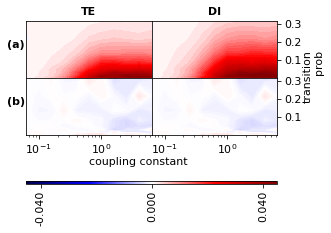

In [25]:
# $fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, gridspec_kw={'hspace':0, 'wspace':0},
#                        figsize=(3., 3.0))

fig = plt.figure(figsize=(4.5, 3.0))
gs = mpl.gridspec.GridSpec(100, 100)
ax = np.array([[fig.add_subplot(gs[:35, :50]), fig.add_subplot(gs[:35, 50:])],
             [fig.add_subplot(gs[35:70, :50]), fig.add_subplot(gs[35:70, 50:])]])

x = coupling_js
y = driver_ps

zs = [(te_forw-te_backw).mean(axis=2), 
      (d-r).mean(axis=2)]
z_contrls = [(te_forw_control-te_backw_control).mean(axis=2), 
             (d_control-r_control).mean(axis=2)]

vmax = max([z.max() for z in zs + z_contrls])
vmin = -vmax

normalizer = mpl.colors.Normalize(vmax, vmin)

imgs = []
for z, z_contrl, ax_col in zip(zs, z_contrls, ax.T):
    
    i = ax_col[0].contourf(x, y, z, 30, vmin=vmin, vmax=vmax, norm=normalizer, cmap='seismic')
    icontr = ax_col[1].contourf(x, y, z_contrl, 30, vmin=vmin, vmax=vmax, norm=normalizer, cmap='seismic')
    imgs += [i, icontr]

for _ax in ax.flat:
    _ax.semilogx()

ax[1, 0].set_xlabel('coupling constant', ha='left')
ax[1, 1].tick_params(axis='x', which='minor')

#_ax = ax[1, 1]
locmin = mpl.ticker.LogLocator(base=10.0,subs=(.1, 0.2,.3, 0.4,.5, 0.6,.7,0.8,.9), numticks=12)
for _ax in ax[1, :]:
    _ax.xaxis.set_minor_locator(locmin)
    _ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


ax[0, -1].set_ylabel('transition\nprob', ha='right', va='bottom')

ax[0, 0].set_ylabel('(a)', labelpad=10, fontweight='bold', rotation=0)
ax[1, 0].set_ylabel('(b)', labelpad=10, fontweight='bold', rotation=0)
ax[0, -1].yaxis.set_label_position('right')
ax[1, -1].yaxis.set_label_position('right')
ax[0, 0].set_title('TE')
ax[0, 1].set_title('DI')

for _ax in ax[:, :-1].flat: _ax.set_yticks([])
for _ax in ax[:, -1]: _ax.yaxis.tick_right()
for _ax in ax[0, :]: _ax.set_xticks([])



# colorbar

ax_col = fig.add_subplot(gs[98:, :])
i = mpl.cm.ScalarMappable(norm=normalizer, cmap='seismic')

cbar = fig.colorbar(i,
                    orientation='horizontal', cax=ax_col)#, pad=.3, shrink=.9)
ticks = [cbar.get_ticks()[0], cbar.get_ticks()[-1]]
if 0 not in ticks:
    ticks.insert(1, 0)
cbar.set_ticks(ticks)
cbar.ax.set_xticklabels(['{:.3f}'.format(f) for f in ticks], rotation=90)

fig.savefig('/home/mi/thempel/Dokumente/Papers/paper_directed_networks/gfx/ising_te_di.pdf', bbox_inches='tight')

### also compute CTW estimators for comparison
NOTES:
- CTW: have to time-lag trajectories, otherwise numerical values are different. makes sense as the MSM is also returning probabilities of that lag time and values have to be comparable.
- use a memory depth of 3, i.e., follow history up to 3 steps into the past
- computation is super slow...


In [8]:
from pathos.multiprocessing import Pool
from contextlib import closing

CTW_VARNAMES = ['_d_i3_ctw', '_d_i4_ctw', '_r_i3_ctw', '_r_i4_ctw', 
           '_d_i3_ctw_control', '_d_i4_ctw_control', '_r_i3_ctw_control', '_r_i4_ctw_control']


def compute_ctw(states):
    """
    compute all ctw estimators; 
    ATTENTION: trajectories will be time lagged.
    """
    
    # 1.4 driver - neighbor estimates
    # forward
    states_0 = inf.utils.lag_observations([states[0]], msmlag)
    states_1 = inf.utils.lag_observations([states[1]], msmlag)
    
    p = inf.CTWProbabilities(D=3)
    est = inf.JiaoI3(p)
    

    est.estimate(states_0, states_1)
    _d_i3_ctw = est.d

    est = inf.JiaoI4(p)
    est.estimate(states_0, states_1)
    _d_i4_ctw = est.d

    # backward
    p = inf.CTWProbabilities(D=3)
    est = inf.JiaoI3(p)
    est.estimate(states_1, states_0)
    _r_i3_ctw = est.d

    est = inf.JiaoI4(p)
    est.estimate(states_1, states_0)
    _r_i4_ctw = est.d

    #### 2 control
    # control estimates
    # forward
    
    states_5 = inf.utils.lag_observations([states[5]], msmlag)
    states_6 = inf.utils.lag_observations([states[6]], msmlag)
    
    p = inf.CTWProbabilities(D=3)
    est = inf.JiaoI3(p)
    est.estimate(states_5, states_6)
    _d_i3_ctw_control = est.d

    est = inf.JiaoI4(p)
    est.estimate(states_5, states_6)
    _d_i4_ctw_control = est.d

    # backward
    p = inf.CTWProbabilities(D=3)
    est = inf.JiaoI3(p)
    est.estimate(states_6, states_5)
    _r_i3_ctw_control = est.d

    est = inf.JiaoI4(p)
    est.estimate(states_6, states_5)
    _r_i4_ctw_control = est.d
    return_ = {}
    for name in CTW_VARNAMES:
        return_[name] = eval(name)
    return return_

In [ ]:
pool = Pool(processes=8)


# flatten array
args = []
t = 0 # only one trial
for n, p_self in enumerate(driver_ps):
    for m, p in enumerate(coupling_js):
        args.append((n, m, states_allruns[n, m, t]))

pbar = tqdm(total=len(args))
with closing(pool):
    res_async = [pool.apply_async(compute_ctw, (a[2], ), callback=lambda _: pbar.update(1)) for a in args]
    results = [(a[0], a[1], x.get()) for a, x in zip(args, res_async)]
    
pbar.close()

In [13]:
d_i3_ctw = np.zeros(ashape)
r_i3_ctw = np.zeros(ashape)
d_i4_ctw = np.zeros(ashape)
r_i4_ctw = np.zeros(ashape)

d_i3_ctw_control = np.zeros(ashape)
r_i3_ctw_control = np.zeros(ashape)

d_i4_ctw_control = np.zeros(ashape)
r_i4_ctw_control = np.zeros(ashape)


#for t in range(n_trails):

print('{} of {}'.format(t, n_trails))

for n, m, res in results:
    d_i3_ctw[n, m, t] = res['_d_i3_ctw']
    d_i4_ctw[n, m, t] = res['_d_i4_ctw']
    r_i3_ctw[n, m, t] = res['_r_i3_ctw']
    r_i4_ctw[n, m, t] = res['_r_i4_ctw']
    
    d_i3_ctw_control[n, m, t] = res['_d_i3_ctw_control']
    d_i4_ctw_control[n, m, t] = res['_d_i4_ctw_control']
    
    r_i3_ctw_control[n, m, t] = res['_r_i4_ctw_control']
    r_i4_ctw_control[n, m, t] = res['_r_i4_ctw_control']

0 of 3


In [14]:
np.savez('glauber_states_ctw.npz', 
         d_i3_ctw=d_i3_ctw, r_i3_ctw=r_i3_ctw, 
         d_i4_ctw=d_i4_ctw, r_i4_ctw=r_i4_ctw,
         d_i3_ctw_control=d_i3_ctw_control, r_i3_ctw_control=r_i3_ctw_control,
         d_i4_ctw_control=d_i4_ctw_control, r_i4_ctw_control=r_i4_ctw_control)

In [20]:
ctw_data = np.load('glauber_states_ctw.npz')

In [21]:
d_i3_ctw = ctw_data["d_i3_ctw"]
r_i3_ctw = ctw_data["r_i3_ctw"]
d_i4_ctw = ctw_data["d_i4_ctw"]
r_i4_ctw = ctw_data["r_i4_ctw"]
d_i3_ctw_control = ctw_data["d_i3_ctw_control"]
r_i3_ctw_control = ctw_data["r_i3_ctw_control"]
d_i4_ctw_control = ctw_data["d_i4_ctw_control"]
r_i4_ctw_control = ctw_data["r_i4_ctw_control"]

### plot all estimators: SI Fig. 1

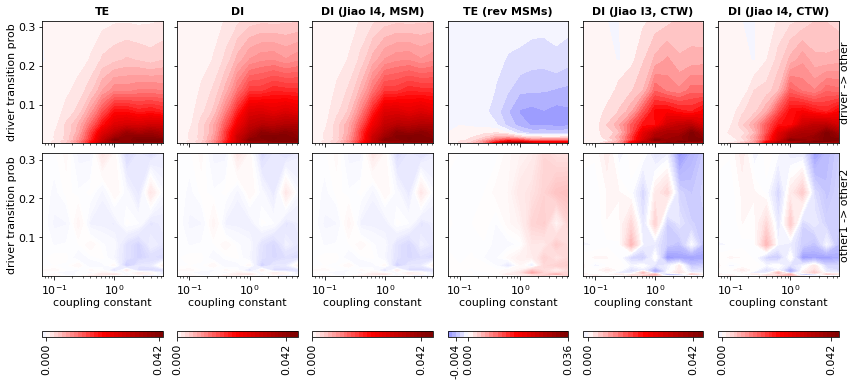

In [26]:
fig, ax = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(12, 6))

x = coupling_js
y = driver_ps

zs = [(te_forw-te_backw).mean(axis=2), 
      (d-r).mean(axis=2), 
      (d_i4-r_i4).mean(axis=2), 
      (te_forw_rev-te_backw_rev).mean(axis=2),
      (d_i3_ctw-r_i3_ctw)[:, :, 0], # THE OTHER ONES ARE NOT COMPUTED!
     (d_i4_ctw-r_i4_ctw)[:, :, 0] # same
     ]
z_contrls = [(te_forw_control-te_backw_control).mean(axis=2), 
             (d_control-r_control).mean(axis=2), 
             (d_i4_control-r_i4_control).mean(axis=2), 
             (te_forw_rev_control-te_backw_rev_control).mean(axis=2), 
            (d_i3_ctw_control-r_i3_ctw_control)[:, :, 0], ###
            (d_i4_ctw_control-r_i4_ctw_control)[:, :, 0] ###
            ]

imgs = []
for z, z_contrl, ax_col in zip(zs, z_contrls, ax.T):

    vmax = max(z.max(), z_contrl.max())
    vmin = -vmax
    i = ax_col[0].contourf(x, y, z, 30, vmin=vmin, vmax=vmax, cmap='seismic')
    ax_col[1].contourf(x, y, z_contrl, 30, vmin=vmin, vmax=vmax, cmap='seismic')
    imgs.append(i)

ax[0, 0].semilogx()

for _ax in ax[1, :]: _ax.set_xlabel('coupling constant')
for _ax in ax[:, 0]: _ax.set_ylabel('driver transition prob')
ax[0, -1].set_ylabel('driver -> other')
ax[1, -1].set_ylabel('other1 -> other2')
ax[0, -1].yaxis.set_label_position('right')
ax[1, -1].yaxis.set_label_position('right')
ax[0, 0].set_title('TE')
ax[0, 1].set_title('DI')
ax[0, 2].set_title('DI (Jiao I4, MSM)')
ax[0, 3].set_title('TE (rev MSMs)')
ax[0, 4].set_title('DI (Jiao I3, CTW)')
ax[0, 5].set_title('DI (Jiao I4, CTW)')
#ax[0,0].loglog()
fig.tight_layout()

# colorbars
for i, ax_col in zip(imgs, ax.T):
    cbar = fig.colorbar(i, orientation='horizontal', ax=ax_col)
    ticks = [cbar.get_ticks()[0], cbar.get_ticks()[-1]]
    if 0 not in ticks:
        ticks.insert(1, 0)
    cbar.set_ticks(ticks)
    cbar.ax.set_xticklabels(['{:.3f}'.format(f) for f in ticks], rotation=90)
    
fig.savefig('/home/mi/thempel/Dokumente/Papers/paper_directed_networks/gfx/ising_all_methods.pdf',
           bbox_inches='tight')

### plot raw values without taking difference
Not used in paper, only for understanding

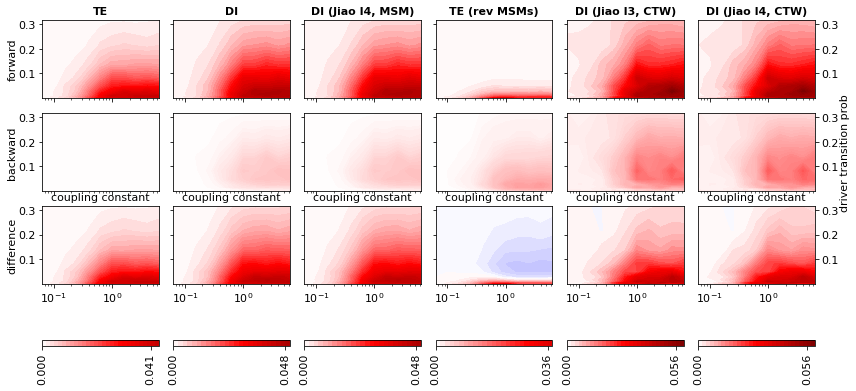

In [23]:
fig, ax = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(12, 6))

x = coupling_js
y = driver_ps

zs = [(te_forw).mean(axis=2), 
      (d).mean(axis=2), 
      (d_i4).mean(axis=2), 
      (te_forw_rev).mean(axis=2),
      (d_i3_ctw)[:, :, 0],
     (d_i4_ctw)[..., 0]]
zs_backw = [(te_backw).mean(axis=2), 
             (r).mean(axis=2), 
             (r_i4).mean(axis=2), 
             (te_backw_rev).mean(axis=2), 
            (r_i3_ctw)[:, :, 0],
            (r_i4_ctw)[:, :, 0]]


vmax = max([z.max() for z in zs + z_contrls])
vmin = -vmax
normalizer = mpl.colors.Normalize(vmax, vmin)

imgs = []
for z, z_backw, ax_col in zip(zs, zs_backw, ax.T):
    i = ax_col[0].contourf(x, y, z, 30, vmin=vmin, vmax=vmax, cmap='seismic')
    ax_col[1].contourf(x, y, z_backw, 30, vmin=vmin, vmax=vmax, cmap='seismic')
    ax_col[2].contourf(x, y, z-z_backw, 30, vmin=vmin, vmax=vmax, cmap='seismic')
    imgs.append(i)

ax[0, 0].semilogx()

for _ax in ax[1, :]: _ax.set_xlabel('coupling constant')

ax[0, 0].set_ylabel('forward')
ax[1, 0].set_ylabel('backward')
ax[2, 0].set_ylabel('difference')
ax[1, -1].yaxis.set_label_position('right')
for _ax in ax[:, -1]: _ax.yaxis.set_ticks_position('right')
ax[1, -1].set_ylabel('driver transition prob')
ax[0, 0].set_title('TE')
ax[0, 1].set_title('DI')
ax[0, 2].set_title('DI (Jiao I4, MSM)')
ax[0, 3].set_title('TE (rev MSMs)')
ax[0, 4].set_title('DI (Jiao I3, CTW)')
ax[0, 5].set_title('DI (Jiao I4, CTW)')
#ax[0,0].loglog()
fig.tight_layout()

# colorbars
for i, ax_col in zip(imgs, ax.T):
    cbar = fig.colorbar(i, orientation='horizontal', ax=ax_col)
    ticks = [cbar.get_ticks()[0], cbar.get_ticks()[-1]]
    if 0 not in ticks:
        ticks.insert(1, 0)
    cbar.set_ticks(ticks)
    cbar.ax.set_xticklabels(['{:.3f}'.format(f) for f in ticks], rotation=90)
